In [1]:
import re
import mdtraj as md
import mdfeature.features as features
import numpy as np
import dill
import os, glob
from mdfeature.ConvergenceAnalyser import free_energy_estimate_2D
import pyemma
from mdfeature.KramersRateEvaluator import KramersRateEvaluator
import pydiffmap.diffusion_map as dfm
import mdfeature.features as features
from time import time
import mdtraj
from pyemma.coordinates.data.featurization.angles import DihedralFeature
from mdfeature.analine_free_energy import compute_dihedral_trajectory
import matplotlib.tri as tri

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
font = {'family' : 'sans-serif',
        'size'   : 14.0}
mpl.rc('font', **font) 
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] =  16
mpl.rcParams['font.size'] =  15
mpl.rcParams['figure.autolayout'] =  True
mpl.rcParams['figure.figsize'] =  7.2,4.45
mpl.rcParams['axes.titlesize'] =  16
mpl.rcParams['axes.labelsize'] =  17
mpl.rcParams['lines.linewidth'] =  2
mpl.rcParams['lines.markersize'] =  6
mpl.rcParams['legend.fontsize'] =  13

In [12]:
import openmm.unit as unit

unit_labels = {
    "us": unit.microseconds,
    "ns": unit.nanoseconds,
    "ps": unit.picoseconds,
    "fs": unit.femtoseconds
}


def parse_quantity(s):
    try:
        u = s.lstrip('0123456789.')
        v = s[:-len(u)]
        return unit.Quantity(
            float(v),
            unit_labels[u]
        )
    except Exception:
        raise ValueError(f"Invalid quantity: {s}")
        
def subsample_trajectory(trajectory, stride):
    traj = md.Trajectory(trajectory.xyz[::stride], trajectory.topology)
    return traj.superpose(traj[0]) 

def check_and_remove_nans(data, axis=1):
    num_nans = np.count_nonzero(np.isnan(data)) 
    if num_nans > 0:
        axis_str = "rows" if axis==1 else "columns"
        print(f"{num_nans} NaNs detected, removing {axis_str} with NaNs.")
        data = data[~np.isnan(data).any(axis=1), :]
        
    return data


    
class Experiment:
    
    #TODO: fix bug when default torsions = None

        def __init__(self, location, temperature, duration, savefreq, stepsize, default_torsions=None, dihedral_pickle_file=None, dihedrals=None, metad_bias_file=None):
            self.temperature = temperature
            self.duration = parse_quantity(duration)
            self.savefreq = parse_quantity(savefreq)
            self.stepsize = parse_quantity(stepsize)
            self.iterations = int(self.duration / self.stepsize)
            self.beta = 1/(self.temperature*0.0083144621)
            print("Successfully initialised experiment metadata.")
            
            self.pdb = self.load_pdb(location)
            self.topology = self.pdb.topology
            self.trajectory = self.load_trajectory(location, self.topology)
            if dihedral_pickle_file is not None:
                self.dihedral_traj = self.load_dihedral_trajectory(location, dihedral_pickle_file)
            else:
                self.dihedral_traj = self._compute_dihedral_traj(location, dihedrals)
            assert len(self.trajectory) > 0, "Trajectory is empty."
            assert len(self.dihedral_traj) > 0, "Dihedral trajectory is empty."
            if metad_bias_file is not None:
                self.metad_weights, self.bias_potential_traj = self._load_metad_bias(metad_bias_file)
                assert len(self.metad_weights) == len(self.trajectory), f"metadynamics weights (len {len(self.metad_weights)}) and trajectory (len {len(self.trajectory)}) must have the same length."
            else:
                self.metad_weights = None
            self.conformations = len(self.trajectory)
            assert np.abs(self.conformations - int(self.duration/self.savefreq)) <= 1, f"duration ({duration}) and savefreq ({savefreq}) incompatible with number of conformations found in trajectory (got {self.conformations}, expected {int(self.duration/self.savefreq)})."
            print("Successfully loaded experiment data.")
            
            self.featurizer = self.initialise_featurizer(default_torsions)
            self.featurized_trajectory = self.featurizer.transform(self.trajectory)
            self.mean_features = np.mean(self.featurized_trajectory, axis=0)
            self.fluctuations_features = np.std(self.featurized_trajectory, axis=0)
            print("Successfully featurized trajectory.")

            self.PCA = None
            self.TICA = None
            self.VAMP = None
            self.kre = KramersRateEvaluator()
            self.kre_params = {'minimum_counts':25,'bins':200,'impute_free_energy_nans':True,
                               'cluster_type':'kmeans','k':100,'ignore_high_energy_minima':False,
                              'include_endpoint_minima':True,'minima_prominence':1.5,'options':None}
            self.dmap = dfm.DiffusionMap.from_sklearn(epsilon = 'bgh', alpha = 0.5, k=64, kernel_type='gaussian', n_evecs=5, neighbor_params=None,
                             metric='euclidean', metric_params=None, weight_fxn=None, density_fxn=None, bandwidth_type="-1/(d+2)",
                             bandwidth_normalize=False, oos='nystroem')
            self.discrete_traj = None
            
        def flip_dihedral_coords(self):
            print(self.dihedral_traj.shape)
            temp = self.dihedral_traj[:,0].copy()
            self.dihedral_traj[:,0] = self.dihedral_traj[:,1]
            self.dihedral_traj[:,1] = temp
            print(self.dihedral_traj.shape)

        @staticmethod
        def _compute_dihedral_traj(loc, dihedrals):
            pdb = glob.glob(os.path.join(loc, '*.pdb'))[0]
            traj = glob.glob(os.path.join(loc, "*.dcd"))[0]
            dihedral_traj = np.array(compute_dihedral_trajectory(pdb, traj, dihedrals)).T
            # correcting order
            dihedral_traj[:,[0, 1]] = dihedral_traj[:,[1, 0]]
            return dihedral_traj
        
        def _load_metad_bias(self, bias_file, col_idx=2):
            colvar = np.genfromtxt(bias_file, delimiter=' ')
            assert col_idx < colvar.shape[1], "col_idx must not exceed 1 less than the number of columns in the bias file"
            bias_potential_traj = colvar[:,col_idx]#[::500][:-1]
            weights = np.exp(self.beta * bias_potential_traj)
            return weights, bias_potential_traj
        
        @staticmethod
        def _slice(data, quantity):
            if data is None:
                return None
            else:
                print(data[:quantity])
                return data[:quantity]
        
        @staticmethod
        def load_pdb(loc):
            print(glob.glob(os.path.join(loc)))
            pdb_files = glob.glob(os.path.join(loc, '*.pdb'))
            assert len(pdb_files) <= 1, f"Read error: more than one PDB file found in the directory ({pdb_files})."
            assert len(pdb_files) != 0, f"Read error: no PDB files found in directory."
            return md.load_pdb(pdb_files[0])
        
        @staticmethod
        def load_trajectory(loc, topology):
            traj_files = glob.glob(os.path.join(loc, '*.dcd'))
            assert len(traj_files) <= 1, f"Read error: more than one traj file found in the directory ({traj_files})."
            assert len(traj_files) != 0, f"Read error: no traj files found in directory."
            return mdtraj.load(traj_files[0], top=topology)
        
        @staticmethod
        def load_dihedral_trajectory(loc, dihedral_pickle_file):
            dihedral_traj = np.array(dill.load(open(os.path.join(loc,dihedral_pickle_file), "rb"))).T
            # correcting order
            dihedral_traj[:,[0, 1]] = dihedral_traj[:,[1, 0]]
            return dihedral_traj
        
        def initialise_featurizer(self, default_torsions):
            # To check
            featurizer = pyemma.coordinates.featurizer(self.topology)
            dihedral_indices = features.create_torsions_list(atoms=self.topology.n_atoms, size=0, append_to=default_torsions, print_list=False)
            featurizer.add_dihedrals(dihedral_indices, cossin=True)
            featurizer.describe()
            return featurizer

        def ramachandran_plot(self, data_fraction=1, bins=100, nan_threshold=50, rotate=False, low_threshold=None, save_fig=False, save_name='ramachandran_plot.pdf'):
            if self.metad_weights is None:
                dihedral_traj = check_and_remove_nans(self.dihedral_traj)
                final_iteration = int(data_fraction * len(dihedral_traj))
                free_energy, xedges, yedges = free_energy_estimate_2D(dihedral_traj[:final_iteration], self.beta, bins=bins, weights=self._slice(self.metad_weights,final_iteration))
                fig, ax = plt.subplots()
                if rotate is True:
                    free_energy = free_energy.T
                if low_threshold is None:
                    masked_free_energy = np.ma.array(free_energy, mask=(free_energy > nan_threshold))
                else:
                    masked_free_energy = np.ma.array(free_energy, mask=(np.logical_or((free_energy > nan_threshold),(free_energy < low_threshold))))
                im = ax.pcolormesh(xedges, yedges, masked_free_energy)
                cbar = plt.colorbar(im)
                cbar.set_label(r'$\mathcal{F}(\phi,\psi)$ / kJmol$^{-1}$')
                plt.xticks(np.arange(-3, 4, 1))
                plt.xlabel(r'$\phi$')
                plt.ylabel(r'$\psi$')
                plt.gca().set_aspect('equal')
            else:
                xyz = check_and_remove_nans(np.hstack([self.dihedral_traj, np.array([self.bias_potential_traj]).T]))
                x = xyz[:,0]
                y = xyz[:,1]
                z = xyz[:,2]
                fe = -z + np.max(z)
                fig, ax = plt.subplots()
                #set level increment every unit of kT
                num_levels = int(np.floor((np.max(fe)-np.min(fe)) / 2.5))
                levels = [k * 2.5 for k in range(num_levels+2)]
                if rotate is True:
                    cntr2 = ax.tricontourf(y, x, -z + np.max(z), levels=levels, cmap="RdBu_r")
                    ax.tricontour(y, x, -z, levels=levels, linewidths=0.5, colors='k')
                else:
                    cntr2 = ax.tricontourf(x, y, -z + np.max(z), levels=levels, cmap="RdBu_r")
                    ax.tricontour(x, y, -z, levels=levels, linewidths=0.5, colors='k')
                plt.xlabel(r'$\phi$')
                plt.ylabel(r'$\psi$')
                plt.gca().set_aspect('equal')
                cbar = fig.colorbar(cntr2, ax=ax)
                cbar.set_label(r'$\mathcal{F}(\phi,\psi)$ / kJmol$^{-1}$')
                ax.set(xlim=(-np.pi, np.pi), ylim=(-np.pi, np.pi))
                plt.xticks(np.arange(-3, 4, 1))
                plt.subplots_adjust(hspace=0.5)

            if save_fig:
                plt.savefig(save_name, format="pdf", bbox_inches="tight")
            plt.show()    
            
            return masked_free_energy, pd.DataFrame(np.vstack([dihedral_traj,]), columns=['phi','psi','weight'])
            
        def implied_timescale_analysis(self, max_lag=10, k=10):
            if self.discrete_traj is None:
                cluster = pyemma.coordinates.cluster_kmeans(self.featurized_trajectory, k=k)
                self.discrete_traj = cluster.dtrajs[0]
            its = pyemma.msm.its(self.discrete_traj, lags=max_lag)
            pyemma.plots.plot_implied_timescales(its)


        def compute_PCA(self, dim, stride=1, featurized=True):
            t0 = time()
            trajectory = self.featurized_trajectory if featurized else self.trajectory
            self.PCA = pyemma.coordinates.pca(trajectory, dim=dim, stride=stride)
            t1 = time()
            print(f"Computed PCA in {round(t1-t0,3)}s.")

        def compute_TICA(self, dim, lag, stride=1, featurized=True, kinetic_map=True):
            t0 = time()
            trajectory = self.featurized_trajectory if featurized else self.trajectory
            self.TICA = pyemma.coordinates.tica(trajectory, lag=lag, dim=dim, stride=stride, kinetic_map=kinetic_map)
            t1 = time()
            print(f"Computed TICA in {round(t1-t0,3)}s.")

        def compute_VAMP(self, dim, lag, stride=1, featurized=True):
            t0 = time()
            trajectory = self.featurized_trajectory if featurized else self.trajectory
            self.VAMP = pyemma.coordinates.vamp(trajectory, lag=lag, dim=dim, stride=stride)
            t1 = time()
            print(f"Computed VAMP in {round(t1-t0,3)}s.")
                
        def compute_DMAP(self, stride, featurized=True):
            t0 = time()
            trajectory = self.featurized_trajectory if featurized else self.trajectory
            self.DMAP = self.dmap.fit(trajectory[::stride])
            t1 = time()
            print(f"Computed DMAP in {round(t1-t0,3)}s.")
                
        def analyse_PCA(self, dimension, lag, sigmaD, sigmaF):
            assert self.PCA is not None, "Run compute_PCA before analyse_PCA."
            self.kre.fit(self.PCA.get_output()[0][:,dimension], beta = self.beta, time_step = self.stepsize,
                         lag = lag, sigmaD = sigmaD, sigmaF = sigmaF, **self.kre_params)
            
        def analyse_TICA(self, dimension, lag, sigmaD, sigmaF):
            assert self.TICA is not None, "Run compute_TICA before analyse_TICA."
            self.kre.fit(self.TICA.get_output()[0][:,dimension], beta = self.beta, time_step = self.stepsize, 
                         lag = lag, sigmaD = sigmaD, sigmaF = sigmaF, **self.kre_params)
        
        def analyse_VAMP(self, dimension, lag, sigmaD, sigmaF):
            assert self.VAMP is not None, "Run compute_VAMP before analyse_VAMP."
            self.kre.fit(self.VAMP.get_output()[0][:,dimension], beta = self.beta, time_step = self.stepsize, 
                         lag = lag, sigmaD = sigmaD, sigmaF = sigmaF, **self.kre_params)
            
        def eigenvector(self, CV: str, dim: int):
            self._assert_valid_cv(CV)
            x = None
            if CV == 'PCA':
                x = self.PCA.get_output()[0][:,dim]
                print(x)
                print(x.shape)
            elif CV == 'VAMP':
                x = self.VAMP.get_output()[0][:,dim]
            elif CV == 'DMAP':
                x = self.DMAP.evecs[:,dim]
                print(x)
                print(x.shape)
            elif CV == 'TICA':
                return self.TICA.eigenvectors[:,dim]
            return self._lstsq_traj_with_features(traj=x)
        
        def _lstsq_traj_with_features(self, traj):
            a = self.featurized_trajectory
            a = np.c_[np.ones(self.conformations), a]  
            print("a_shape", a.shape)
            c, err, _, _ = np.linalg.lstsq(a, traj, rcond=None) #TODO: revert back
            
            return c[1:], err
        
        def _assert_valid_cv(self, CV: str):
            assert CV in ['PCA', 'TICA', 'VAMP', 'DMAP'], "CV must be one of PCA, TICA, VAMP, DMAP."
            if CV == 'PCA':
                assert self.PCA is not None, "Run compute_PCA first."
            elif CV == 'TICA':
                assert self.TICA is not None, "Run compute_TICA first."
            elif CV == 'VAMP':
                assert self.VAMP is not None, "Run compute_VAMP first."
            elif CV == 'DMAP':
                assert self.DMAP is not None, "Run compute_DMAP first."

        def create_plumed_metadynamics_script(self, CV: str, filename=None, gaussian_height=0.2, gaussian_pace=1000):
            self._assert_valid_cv(CV)
            f = open("./plumed.py" if filename is None else f"./{filename}.py", 'w')
            output = "plumed_script=\"RESTART " + "\\n\\"
            f.write(output + "\n")
            print(output)
            dihedral_features = Dihedrals(dihedrals=self.featurizer.active_features, 
                                          offsets=self.mean_features, 
                                          coefficients=self.eigenvector(CV, dim=0))
            dihedral_features.write_torsion_labels(file=f)
            dihedral_features.write_transform_labels(file=f)
            dihedral_features.write_combined_label(CV=CV, file=f)
            self._write_metadynamics_line(height=gaussian_height, pace=gaussian_pace, CV=CV, file=f)
            
        def _write_metadynamics_line(self, height, pace, CV, file):
            arg_list = []
            sigma_list = []
            arg_list.append(f"{CV}_%d" % 0)
            sigma_list.append(str(0.1))
            output = "METAD ARG=%s SIGMA=%s HEIGHT=%s FILE=HILLS PACE=%s LABEL=metad" \
                     % (','.join(arg_list), ','.join(sigma_list), \
                        str(height), str(pace)) + " \\n\\"
            print(output)
            file.writelines(output + "\n")
            output = "PRINT ARG=%s,metad.bias STRIDE=%s FILE=COLVAR" % (','.join(arg_list), str(pace)) + " \\n"
            print(output + "\"")
            file.writelines(output + "\"" + "\n")
            file.close()

In [13]:
location = '/home/dominic/PycharmProjects/mdfeature/data/outputs/alanine_1us'#'../data/outputs/alanine_1us'
dihedral_pickle_file = 'alanine_1us_dihedral_traj.pickle'
temperature = 300
duration = "987.036ns" 
savefreq = "1ps"
stepsize = "2fs"
phi = [4, 6, 8 ,14] #dihedral coordinates
psi = [6, 8, 14, 16]
zeta = [1, 4, 6, 8]
theta = [8, 14, 16, 18]
default_torsions = [phi, psi, zeta, theta]
alanine_exp_1us = Experiment(location = location, 
                              dihedral_pickle_file = dihedral_pickle_file,
                              temperature = temperature,
                              duration = duration,
                              savefreq = savefreq,
                              stepsize = stepsize,
                              default_torsions=default_torsions
                              )

Successfully initialised experiment metadata.
['/home/dominic/PycharmProjects/mdfeature/data/outputs/alanine_1us']
Successfully loaded experiment data.
Successfully featurized trajectory.


In [14]:
alanine_exp_1us.compute_PCA(dim = 3, stride=1)
alanine_exp_1us.compute_TICA(dim = 3, lag=64, stride=1)
alanine_exp_1us.compute_VAMP(dim = 3, lag=64, stride=1)

Computed PCA in 0.059s.
Computed TICA in 0.156s.
Computed VAMP in 0.161s.


In [25]:
alanine_dmap = dill.load(open('../data/outputs/alanine_1us/alanine_exp_1us_s2_dm.pickle','rb')).DMAP
alanine_exp_1us.DMAP = alanine_dmap

In [15]:
eig, err = alanine_exp_1us.eigenvector('PCA', dim=0)

[ 1.1606867   1.3386797   1.4454519  ... -0.81000274 -0.87689567
  0.77636606]
(987036,)
a_shape (987036, 9)


In [16]:
print(eig, err)

[-5.23343784e-01  1.48631860e-01 -8.32359898e-01 -1.00144500e-01
  2.89644993e-05  3.17460227e-02 -1.62893104e-04  1.26529117e-02] [4.26206718e-10]


In [54]:
def lstsq_traj_with_features(self, traj, subsample):
    a = self.featurized_trajectory
    a = np.c_[np.ones(self.conformations), a]  
    print("a_shape", a.shape)
    c, ssr, _, _ = np.linalg.lstsq(a[::subsample], traj, rcond=None) 
    M, N = a.shape
    dof = M - N
    s2 = ssr / dof
    covA = a.T @ a
    diagCovA = np.diag(covA)
    err_c = np.sqrt(s2 * (1/diagCovA))

    return c[1:], err_c[1:]


def eigenvector(self, CV: str, dim: int, subsample=1):
    self._assert_valid_cv(CV)
    x = None
    if CV == 'PCA':
        x = self.PCA.get_output()[0][:,dim]
        print(x)
        print(x.shape)
    elif CV == 'VAMP':
        x = self.VAMP.get_output()[0][:,dim]
    elif CV == 'DMAP':
        x = self.DMAP.evecs[:,dim]
        print(x)
        print(x.shape)
    elif CV == 'TICA':
        x = self.TICA.get_output()[0][:,dim]
    return lstsq_traj_with_features(self, traj=x, subsample=subsample)

eig_PCA, err_PCA = eigenvector(alanine_exp_1us, 'PCA', dim=0)
eig_TICA, err_TICA = eigenvector(alanine_exp_1us, 'TICA', dim=0)
eig_VAMP, err_VAMP = eigenvector(alanine_exp_1us, 'VAMP', dim=0)
eig_DMAP, err_DMAP = eigenvector(alanine_exp_1us, 'DMAP', dim=0, subsample=2)

[ 1.1606867   1.3386797   1.4454519  ... -0.81000274 -0.87689567
  0.77636606]
(987036,)
a_shape (987036, 9)
a_shape (987036, 9)
a_shape (987036, 9)
[-0.00016758 -0.00016758 -0.00016758 ... -0.00016758 -0.00016758
 -0.00016758]
(493518,)
a_shape (987036, 9)


In [124]:
def normalise(array):
    array = np.array(array)
    sum_squares = np.sum((array)**2)
    array /= np.sqrt(sum_squares)
    return array

def rescale_errors(dataarray, errarray):
    normalised_array = normalise(dataarray)
    rescale_factors = normalised_array / dataarray
    return np.abs(rescale_factors) * errarray

In [131]:
alanine_exp_1us.featurizer
print(normalise(eig_TICA))
print(normalise(eig_VAMP))
print(normalise(eig_DMAP))

[ 0.34064384  0.9296643   0.01615939 -0.02673207  0.12468418 -0.05480146
 -0.00429029  0.01194066]
[ 0.33977447  0.93029323  0.01633229 -0.02542813  0.12274163 -0.054401
 -0.00522093  0.01192674]
[-0.34118288 -0.93079434 -0.01598289  0.02621715 -0.1146227   0.05398513
 -0.00883306 -0.01194011]


In [128]:
import pandas as pd

var = pd.DataFrame({'PCA' : -normalise(eig_PCA),'tICA' : normalise(eig_TICA),'VAMPnet' : normalise(eig_VAMP),'DM' : -normalise(eig_DMAP)})
var2 = pd.DataFrame({'PCA' : rescale_errors(eig_PCA, err_PCA),'tICA' : rescale_errors(eig_TICA, err_TICA),'VAMPnet' : rescale_errors(eig_VAMP, err_VAMP),'DM' : rescale_errors(eig_DMAP, err_DMAP)})

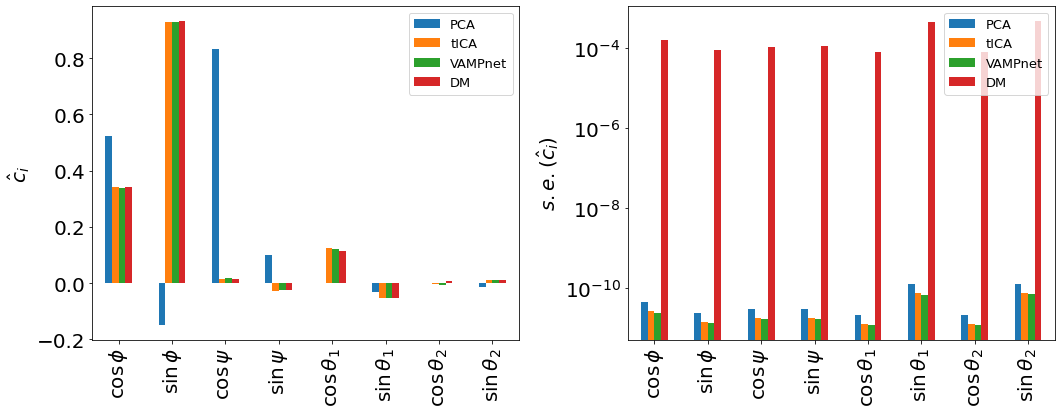

In [130]:
fig, axs = plt.subplots(nrows=1, ncols=2)
var.plot(kind='bar', ax=axs[0])
#axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\hat{c}_i$', fontsize=20)
axs[0].set_xticklabels(fontsize=20, labels=[r'$\cos{\phi}$',r'$\sin{\phi}$',r'$\cos{\psi}$',r'$\sin{\psi}$',r'$\cos{\theta_1}$',r'$\sin{\theta_1}$',r'$\cos{\theta_2}$', r'$\sin{\theta_2}$'])
axs[0].tick_params(axis='y', labelsize=20)

var2.plot(kind='bar', ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$s.e.(\hat{c}_i$)', fontsize=20)
axs[1].set_xticklabels(fontsize=20, labels=[r'$\cos{\phi}$',r'$\sin{\phi}$',r'$\cos{\psi}$',r'$\sin{\psi}$',r'$\cos{\theta_1}$',r'$\sin{\theta_1}$',r'$\cos{\theta_2}$', r'$\sin{\theta_2}$'])
axs[1].tick_params(axis='y', labelsize=20)

fig.set_size_inches(15,6)

plt.savefig('CV_coefficient_comparison.pdf')

In [122]:
def ramachandran_from_x_y_z(x, y, z, rotate, levels=None):
    fig, ax = plt.subplots()
    if rotate is True:
        cntr2 = ax.tricontourf(y, x, z, levels=levels, cmap="RdBu_r")
        ax.tricontour(y, x, z, levels=levels, linewidths=0.5, colors='k')
    else:
        cntr2 = ax.tricontourf(x, y, z, levels=levels, cmap="RdBu_r")
        ax.tricontour(x, y, z, levels=levels, linewidths=0.5, colors='k')
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$\psi$')
    plt.gca().set_aspect('equal')
    cbar = fig.colorbar(cntr2, ax=ax)
    cbar.set_label(r'$\mathcal{F}(\phi,\psi)$ / kJmol$^{-1}$')
    ax.set(xlim=(-np.pi, np.pi), ylim=(-np.pi, np.pi))
    plt.xticks(np.arange(-3, 4, 1))
    plt.subplots_adjust(hspace=0.5)

def ramachandran_from_file(file, rotate=True, savefigname='test.pdf'):
    A = np.genfromtxt(file, delimiter=' ')
    A[A == np.inf] = 50
    num_levels = int(np.floor((np.max(A[:,2])-np.min(A[:,2])) / 2.5))
    levels = [k * 2.5 for k in range(num_levels+2)]
    ramachandran_from_x_y_z(A[:,0],A[:,1],A[:,2]-np.min(A[:,2]),rotate=rotate,levels=levels)
    plt.savefig(savefigname)

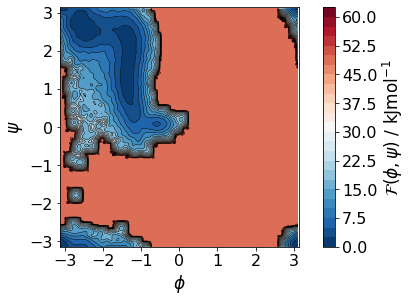

In [123]:
ramachandran_from_file(file="/home/dominic/PycharmProjects/mdfeature/notebooks/test_experiments/ff_PCA2_1.0.dat",
                      rotate=False,savefigname='PCA.pdf')